In [ ]:
import pandas as pd
import numpy as np
import random as rm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


In [ ]:
sequences = pd.read_csv('data/Sequence_Data.csv')

# convert to lowercase
sequences = sequences.applymap(lambda s:s.lower() if type(s) == str else s)
sequences = sequences.applymap(lambda s:s.strip() if type(s) == str else s)

In [ ]:
sequences

In [4]:
flat_sequences = sequences.T.values.flatten()
flat_sequences = flat_sequences.astype('str')

# Remove nans and stop words from the list
flat_sequences = np.delete(flat_sequences, np.where(flat_sequences=='nan')[0])
flat_sequences = np.delete(flat_sequences, np.where(flat_sequences=='stop')[0])

## Classify Poses

In [5]:
global starting_poses
global centering_poses

starting_poses = ['start in childs pose', 
                  'start in easy seat', 
                  'start on back', 
                  'start in supta baddha konasana', 
                  'start in constructive rest pose']

centering_poses = ['ujjayi breathing', 
                   'four-seven-eight breathing', 
                   'legs up the wall', 
                   'roll out neck']

# Remove starting poses from list - these will be randomly selected from at the beginning of each sequence
for i in starting_poses:
    index = np.argwhere(flat_sequences==i)
    flat_sequences = np.delete(flat_sequences, index)

# Remove centering poses from list - these will be randomly selected from at the beginning of each sequence
for i in centering_poses:
    index = np.argwhere(flat_sequences==i)
    flat_sequences = np.delete(flat_sequences, index)

# Remove savasana - this will be tagged on to the end
sav_index = np.argwhere(flat_sequences=="savasana")
flat_sequences = np.delete(flat_sequences, sav_index)


In [6]:
allPoses = np.unique(flat_sequences, return_counts=True)

In [7]:
np.vstack((allPoses[0], allPoses[1])).T

array([['1501.0', '1'],
       ['airplane arms', '16'],
       ['airplane pose', '6'],
       ['anjaneyasana', '27'],
       ['anjaneyasana with hands in prayer', '4'],
       ['baddha konasana', '6'],
       ['bear curl', '4'],
       ['bicycles', '2'],
       ['bird of paradise', '1'],
       ['boat', '17'],
       ['bound prasarita', '2'],
       ['bow', '9'],
       ['bridge', '25'],
       ['cactus arms', '6'],
       ['camel', '1'],
       ['cat cows', '19'],
       ['cat/cow lunges', '11'],
       ['chair', '22'],
       ['chair pose', '7'],
       ['chair twist', '6'],
       ['chaturanga', '20'],
       ['childs pose', '34'],
       ['cobra', '8'],
       ['cobra waves', '10'],
       ['cow', '2'],
       ['crane', '1'],
       ['crescent', '51'],
       ['crescent lunge', '9'],
       ['crescent twist', '20'],
       ['crescent with airplane arms', '1'],
       ['crow', '4'],
       ['dolphin', '7'],
       ['dolphin pose', '2'],
       ['downdog', '85'],
       ['drinking bi

In [8]:
states = allPoses[0]

# Remove nans and stop words from the list
states = np.delete(states, np.where(states=='nan')[0])
states = np.delete(states, np.where(states=='stop')[0])

In [9]:
len(states) # number of unique poses in the dictionary

133

In [10]:
np.savetxt("states.txt", states, fmt='%s')

In [11]:
pose_classes = pd.read_csv("data/pose_classifications.csv")

In [12]:
pose_classes.head()

,pose,class
0,airplane arms,standing
1,airplane pose,standing
2,anjaneyasana,standing
3,anjaneyasana with hands in prayer,standing
4,baddha konasana,warming


In [13]:
global standing
global warming
global cooling 

standing = pose_classes[pose_classes['class']=='standing']
warming = pose_classes[pose_classes['class']=='warming']
cooling = pose_classes[pose_classes['class']=='cooling']

In [14]:
print(len(starting_poses), "starting poses")
print(len(centering_poses), "centering poses")
print(len(warming), "warming poses")
print(len(standing), "standing poses")
print(len(cooling), "cooling poses")


5 starting poses
4 centering poses
38 warming poses
108 standing poses
22 cooling poses


## Create Transition Matrix

In [15]:
def transition_matrix(transitions, states):
    n = len(states) #number of states

    M = np.zeros((n, n))

    for i in range(0, len(transitions)-1):
        index1 = np.where(states==transitions[i])[0]
        index2 = np.where(states==transitions[i+1])[0]
        M[int(index1[0])][int(index2[0])] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
            
    return M

In [16]:
transition_prob = transition_matrix(flat_sequences, states)

## Create Visualizations

In [17]:
def subset_matrix(list, transition_prob):
    n = len(states) #number of states

    M = np.zeros((n, n))
    
    for i in list:
        for j in list:
            if transition_prob[i, j]>0:
                M[i, j]+=1
    
    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    
    M = M[~np.all(M == 0, axis=1)] # remove zero rows
    M = M[:, ~np.all(M == 0, axis=0)] # remove zero columns
    
    labels_list = []
    for i in list:
        labels_list.append(states[i])
    
    ax = sns.heatmap(M, 
                 cmap="YlGnBu", 
                 xticklabels = labels_list,
                 yticklabels = labels_list
                )
    plt.show()

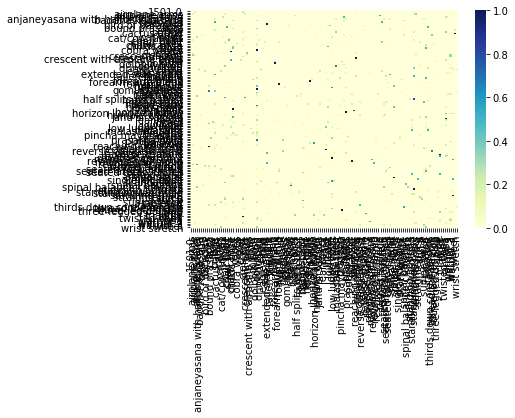

In [18]:
ax = sns.heatmap(transition_prob, 
                 cmap="YlGnBu",
                 xticklabels=states,
                 yticklabels=states
                )
plt.show()

In [19]:
def top_n(M, n):
    rowcounts = []
    
    for row in M:
        count=0
        
        
        for item in row:
            if item > 0:
                count+=1
        rowcounts.append(count)
    
    # get indices of top N items by versatility
    rowcounts = sorted(range(len(rowcounts)), key=lambda i: rowcounts[i], reverse=True)[:n]
    
    return rowcounts

In [20]:
# Find poses with the highest number of connections
top_ten = top_n(transition_prob, 15)
top_ten

[33, 26, 17, 38, 70, 118, 21, 127, 76, 116, 12, 117, 114, 20, 44]

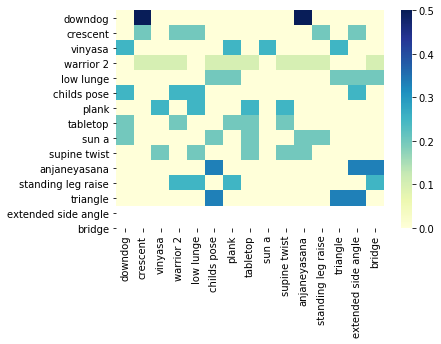

In [21]:
# Find most frequently used poses from allPoses
counts = allPoses[1]
most_used = sorted(range(len(counts)), key=lambda i: counts[i], reverse=True)[:15]

labels_list=[]

for i in most_used:
    labels_list.append(states[i])
    
most_used_matrix = subset_matrix(most_used, transition_prob)

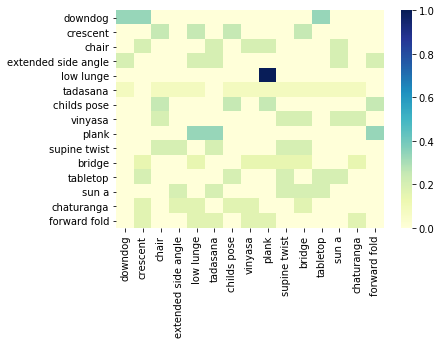

In [22]:
subset_matrix(top_ten, transition_prob)

## Generate Sequences

In [40]:
class MarkovChain(object):
    def __init__(self, transition_prob, states):
        """
        Initialize the MarkovChain instance
        
        Parameters:
        transition_prob: matrix object representing 
        transition probs in Markov Chain.
        """
        self.transition_prob = transition_prob
        self.states = states
    
    def next_state(self, current_state):
        """
        Returns the state of the random variable 
        at the next time instance.
        
        Parameters:
        current_state: str object representing current state of the system
        """
        if isinstance(current_state, (int, float, complex)):
            current_state = current_state
        else:
            index = np.where(states==current_state)[0]
            current_state = int(index[0])
        
        next = np.random.choice(
            list(range(0,len(self.states))), replace=True,
            p=transition_prob[current_state, ]
        )
        
        next = self.states[next]
        
        return next
    
    def generate_states(self, current_state, no=20):
        """
        Generates the next states of the system
        
        Parameters:
        current_state: str : state of the current random var
        
        no: int : the number of future states to generate
        """
        num_warming = int(no/4) # 1/4 of sequence warming
        num_standing = int(no/2) # 1/2 of sequence standing
        num_cooling = int(no/4) # 1/4 of sequence cooling
        
        future_states = []
        
        # Pick a random starting position
        future_states.append(np.random.choice(starting_poses))
        
        # Pick a random centering position
        future_states.append(np.random.choice(centering_poses))
        
        position = len(future_states)
        
        while position < (no+1):
            next_state = self.next_state(current_state)

            # Don't add the same pose twice
            if str(next_state) != str(current_state):
                
                # Add if warming
                if position < num_warming:
                    if str(next_state) in str(warming['pose']):
                        future_states.append(next_state)
                        current_state = next_state
                        position +=1
                # Add if standing
                if (position >= num_warming) & (position < (num_standing + num_warming)):
                    if str(next_state) in str(standing['pose']):
                        future_states.append(next_state)
                        current_state = next_state
                        position+=1
                # Add if cooling
                if position >= (num_standing + num_warming):
                    if str(next_state) in str(cooling['pose']):
                        future_states.append(next_state)
                        current_state = next_state
                        position+=1
        
            else:
                continue
        
        future_states.append('savasana')
        return future_states


In [41]:
MC = MarkovChain(transition_prob, states)

In [42]:
MC.next_state(current_state="downdog")

'low lunge'

In [43]:
first_state = np.random.choice(starting_poses)
generated_class = MC.generate_states(current_state='seated lateral stretch', no=25)
generated_class

['start in childs pose',
 'four-seven-eight breathing',
 'boat',
 'half boat',
 'boat',
 'low boat',
 'tabletop',
 'plank',
 'cobra',
 'childs pose',
 'tabletop',
 'downdog',
 'cobra',
 'childs pose',
 'crescent',
 'airplane arms',
 'airplane pose',
 'standing leg raise',
 'figure 4',
 'seated lateral stretch',
 'forward fold',
 'seated torso circles',
 'seated lateral stretch',
 'supine twist',
 'reclined figure 4',
 'happy baby',
 'savasana']

## Connect to Images

In [ ]:
imgs = pd.read_csv("pose_image_files.csv")
imgs.head()

In [ ]:
generated_class = pd.DataFrame(generated_class, columns = ["pose"])

In [ ]:
class_imgs = pd.merge(generated_class, imgs, on='pose', how='inner')
class_imgs = class_imgs.drop_duplicates(inplace=False)
class_imgs = class_imgs.reset_index()
class_imgs

In [ ]:
images = []
size = 64, 64

for i in class_imgs['image file (all .jpeg)']:
    path = 'images/' + i + '.jpeg'

    try:  
        img = Image.open(path, 'r')
        img.thumbnail(size)
        images.append(img)
    except IOError: 
        pass


In [ ]:
counter=0

for i in images:
    display(i)
#     print(class_imgs['pose'][counter]) # print pose name under the image
    counter+=1


In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(images[i])
plt.show() # or display.display(plt.gcf()) if you prefer

In [ ]:
import matplotlib.pyplot as plt

def grid_display(list_of_images, list_of_titles=[], no_of_columns=4, figsize=(8,6)):

    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

grid = grid_display(images, list_of_titles=class_imgs['pose'])
grid

Sources:
    https://www.datacamp.com/community/tutorials/markov-chains-python-tutorial
    https://medium.com/@__amol__/markov-chains-with-python-1109663f3678
    https://stackoverflow.com/questions/36006136/how-to-display-images-in-a-row-with-ipython-display/38556650
    